In [0]:
import pandas as pd
from IPython.display import Image
from google.colab import files
from google.colab import drive
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from collections import defaultdict
import plotly.graph_objs as go
from plotly import tools
import plotly.offline as py
import numpy as np
import numpy as np 
import pandas as pd 
import bz2
import gc
import re
import os

This step is specific for google colab and will not required if it is experiemented in local or cloud machine

Mount the gdrive by entering the authorization code

In [2]:
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
cd '/content/gdrive/My Drive/Colab Notebooks/NLP-Basic-to-Bert'

/content/gdrive/My Drive/Colab Notebooks/NLP-Basic-to-Bert


In [0]:
#Load the training data
train_df = pd.read_csv('training_data.csv')

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f795e7200f0>],
      dtype=object)

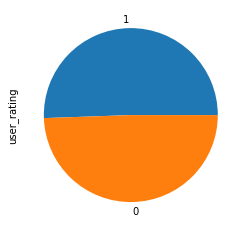

In [6]:
train_df.user_rating.value_counts().plot(kind="pie",subplots=True)

The training data is balanced. Both positive and negative class have almost same training data

In [0]:
# Function to create word cloud
def plot_wordcloud(text, mask=None, max_words=400, max_font_size=120, figure_size=(20.0,15.0), 
                   title = None, title_size=40, image_color=False):
    stopwords = set(STOPWORDS)

    wordcloud = WordCloud(background_color='white',
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 42,
                    mask = mask)
    wordcloud.generate(text)
    
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'green', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()

In [0]:
#Seperate positive and negative classes
postive_df = train_df[train_df.user_rating==1]
negative_df = train_df[train_df.user_rating==0]

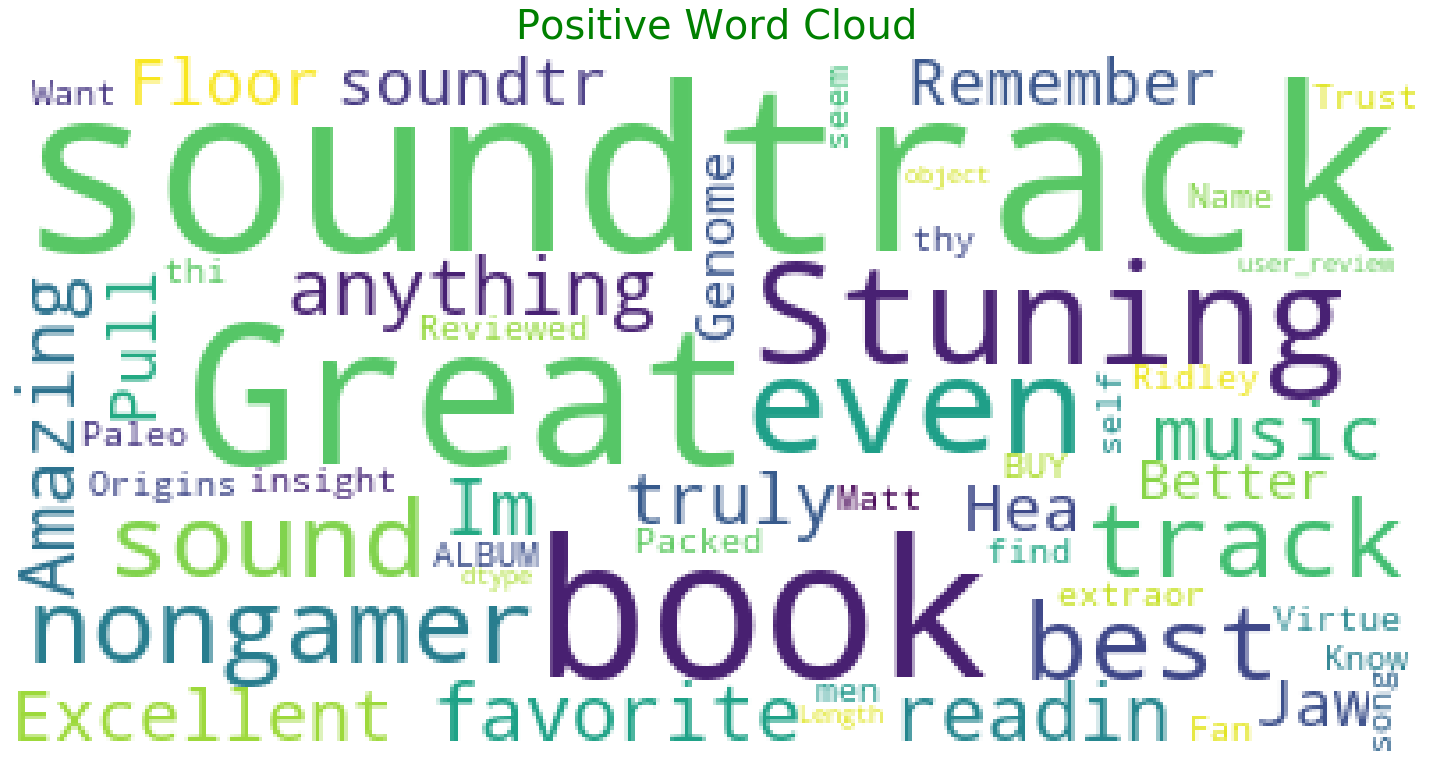

In [11]:
plot_wordcloud(str(postive_df["user_review"]), title="Positive Word Cloud")

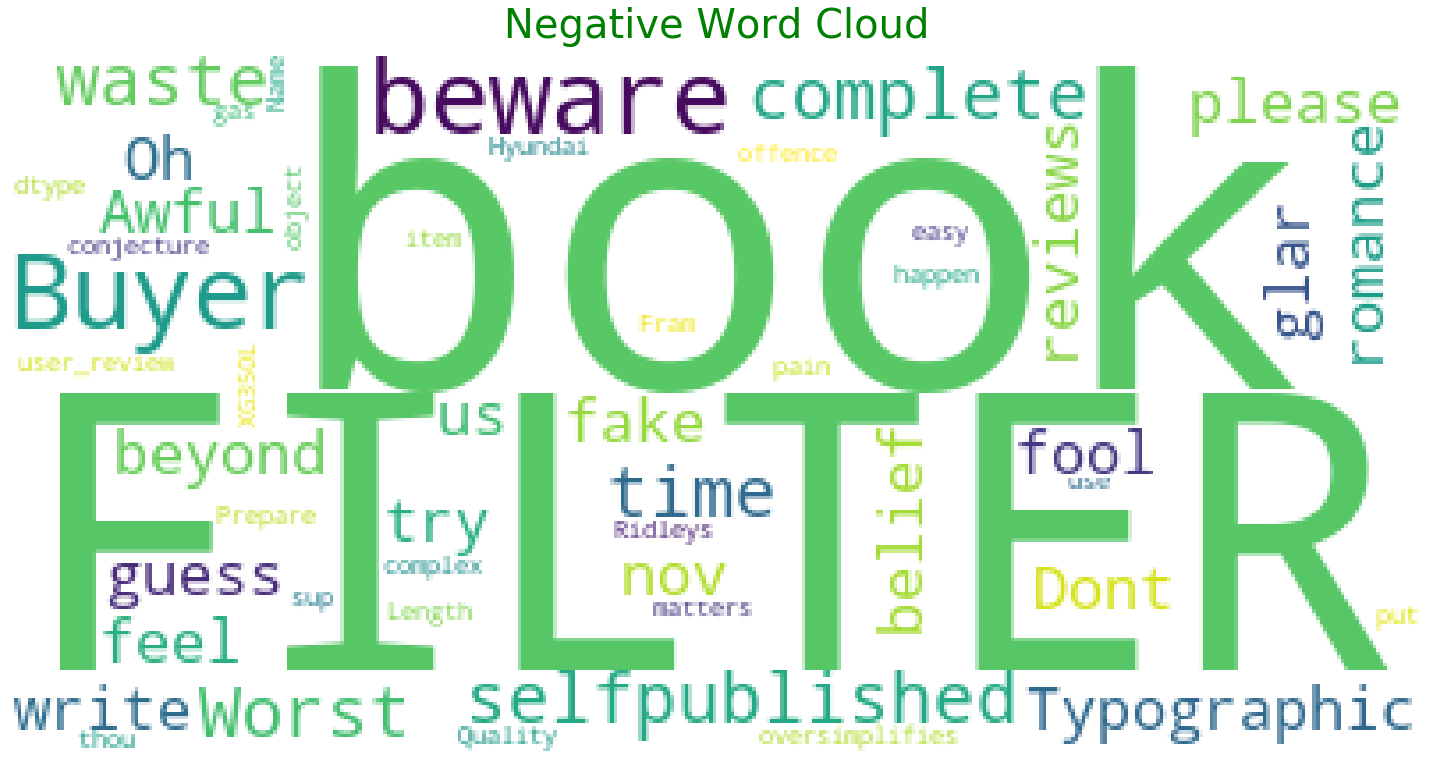

In [12]:
plot_wordcloud(str(negative_df["user_review"]), title="Negative Word Cloud")

The positive words such as Great, Stunning contribute greatly to positive review.  
The negative words such as beware, Awful contribute greatly to negative reviews.

Some neutral words such as book, us, i am are used to both positive and negative reviews

In [0]:
# Function to generate the ngrams
def generate_ngrams(text, n_gram=1):
    token = [token for token in text.lower().split(" ") if token != "" if token not in STOPWORDS]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [" ".join(ngram) for ngram in ngrams]

## custom function for horizontal bar chart ##
def horizontal_bar_chart(df, color):
    trace = go.Bar(
        y=df["word"].values[::-1],
        x=df["wordcount"].values[::-1],
        showlegend=False,
        orientation = 'h',
        marker=dict(
            color=color,
        ),
    )
    return trace

In [14]:
freq_dict = defaultdict(int)
for sent in postive_df["user_review"]:
    for word in generate_ngrams(sent,2):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(50), 'orange')


freq_dict = defaultdict(int)
for sent in negative_df["user_review"]:
    for word in generate_ngrams(sent,2):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(50), 'orange')

# Creating two subplots
fig = tools.make_subplots(rows=1, cols=2, vertical_spacing=0.04,horizontal_spacing=0.15,
                          subplot_titles=["Frequent bigrams of positive comments", 
                                          "Frequent bigrams of negative comments"])
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)
fig['layout'].update(height=1200, width=900, paper_bgcolor='rgb(233,233,233)', title="Bigram Count Plots")
py.iplot(fig, filename='word-plots')

/usr/local/lib/python3.6/dist-packages/plotly/tools.py:465: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



In [0]:
positive_freq_dict = defaultdict(int)
for sent in postive_df["user_review"]:
    for word in generate_ngrams(sent,1):
        positive_freq_dict[word] += 1

negative_freq_dict = defaultdict(int)
for sent in negative_df["user_review"]:
    for word in generate_ngrams(sent,1):
        negative_freq_dict[word] += 1

positive_exclude_keys = positive_freq_dict.keys() - negative_freq_dict.keys()
negative_exclude_keys = negative_freq_dict.keys() - positive_freq_dict.keys()

positive_exclude_dict = defaultdict(int)
for each_key in positive_exclude_keys:
    positive_exclude_dict[each_key] = positive_freq_dict[each_key]
    
negative_exclude_dict = defaultdict(int)
for each_key in negative_exclude_keys:
    negative_exclude_dict[each_key] = negative_freq_dict[each_key]

In [16]:
fd_sorted = pd.DataFrame(sorted(positive_exclude_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(50), 'orange')

fd_sorted = pd.DataFrame(sorted(negative_exclude_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(50), 'orange')

# Creating two subplots
fig = tools.make_subplots(rows=1, cols=2, vertical_spacing=0.04,horizontal_spacing=0.2,
                          subplot_titles=["frequency of excluse positive words", 
                                          "frequency of excluse negative comments"])
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)
fig['layout'].update(height=1200, width=900, paper_bgcolor='rgb(233,233,233)', title="Bigram Count Plots")
py.iplot(fig, filename='word-plots')

/usr/local/lib/python3.6/dist-packages/plotly/tools.py:465: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead

